In [ ]:
#========================================================================
#
# Name: 01 Bike Hire.ipynb
#
# Date: 20/05/2025
#
# Author: MT
# 
# Description: Bike Hire Demand Prediction
# https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand
#
# Steps:
# Step 0: Imports and Locations
# Step 1: Read Data
# Step 2: Prepare Data
# Step 3: Response Variable
#
#========================================================================

In [1]:
#========================================================================
# Step 0: Imports and Locations

# Imports
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 500) # 10000 columns
pd.set_option('display.max_rows', 500) # 10000 rows

# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# XGBoost
from xgboost import XGBRegressor
import xgboost

# SHAP Explainability
import shap
shap.initjs()

# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

# Data
from ucimlrepo import fetch_ucirepo 

#------------------------;
def root_mean_squared_error_group(y_true=None, y_pred=None, group=None):
    """
    Calculate RMSE for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_pred=y_pred[group==this_level]
        values.append(root_mean_squared_error(y_true=this_y_true, y_pred=this_y_pred))
    return pd.DataFrame({'group':levels, 'RMSE':values})
#------------------------;

#------------------------;
def r2_score_group(y_true=None, y_pred=None, group=None):
    """
    Calculate RSQ for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_pred=y_pred[group==this_level]
        values.append(r2_score(y_true=this_y_true, y_pred=this_y_pred))
    return pd.DataFrame({'group':levels, 'RSQ':values})
#------------------------;
#========================================================================

In [35]:
#========================================================================
# Step 1: Read Data
  
# fetch dataset 
seoul_bike_sharing_demand = fetch_ucirepo(id=560)
  
# data (as pandas dataframes) 
X = seoul_bike_sharing_demand.data.features 
y = seoul_bike_sharing_demand.data.targets 
df=pd.concat([y, X], axis=1)

print(df.info())
#========================================================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Functioning Day        8760 non-null   object 
 1   Date                   8760 non-null   object 
 2   Rented Bike Count      8760 non-null   int64  
 3   Hour                   8760 non-null   int64  
 4   Temperature            8760 non-null   float64
 5   Humidity               8760 non-null   int64  
 6   Wind speed             8760 non-null   float64
 7   Visibility             8760 non-null   int64  
 8   Dew point temperature  8760 non-null   float64
 9   Solar Radiation        8760 non-null   float64
 10  Rainfall               8760 non-null   float64
 11  Snowfall               8760 non-null   float64
 12  Seasons                8760 non-null   object 
 13  Holiday                8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.3+ 

In [ ]:
#=================================================================
# Step 2: Prepare Data

# Copy dataframe
df2=copy.deepcopy(df)

# Convert Date to datetime format
df2['DateTime'] = pd.to_datetime(
    df2['Date'] + ' ' + df2['Hour'].astype(str) + ':00',
    format='%d/%m/%Y %H:%M'
)

# Extract Year, Month, and Day of Week from DateTime
df2['Year'] = df2['DateTime'].dt.year
df2['Month'] = df2['DateTime'].dt.month
df2['DayOfWeek'] = df2['DateTime'].dt.strftime('%a')
#=================================================================

,DateTime,Year,Month,DayOfWeek
1000,2018-01-11 16:00:00,2018,1,Thu
1001,2018-01-11 17:00:00,2018,1,Thu
1002,2018-01-11 18:00:00,2018,1,Thu
1003,2018-01-11 19:00:00,2018,1,Thu
1004,2018-01-11 20:00:00,2018,1,Thu
1005,2018-01-11 21:00:00,2018,1,Thu


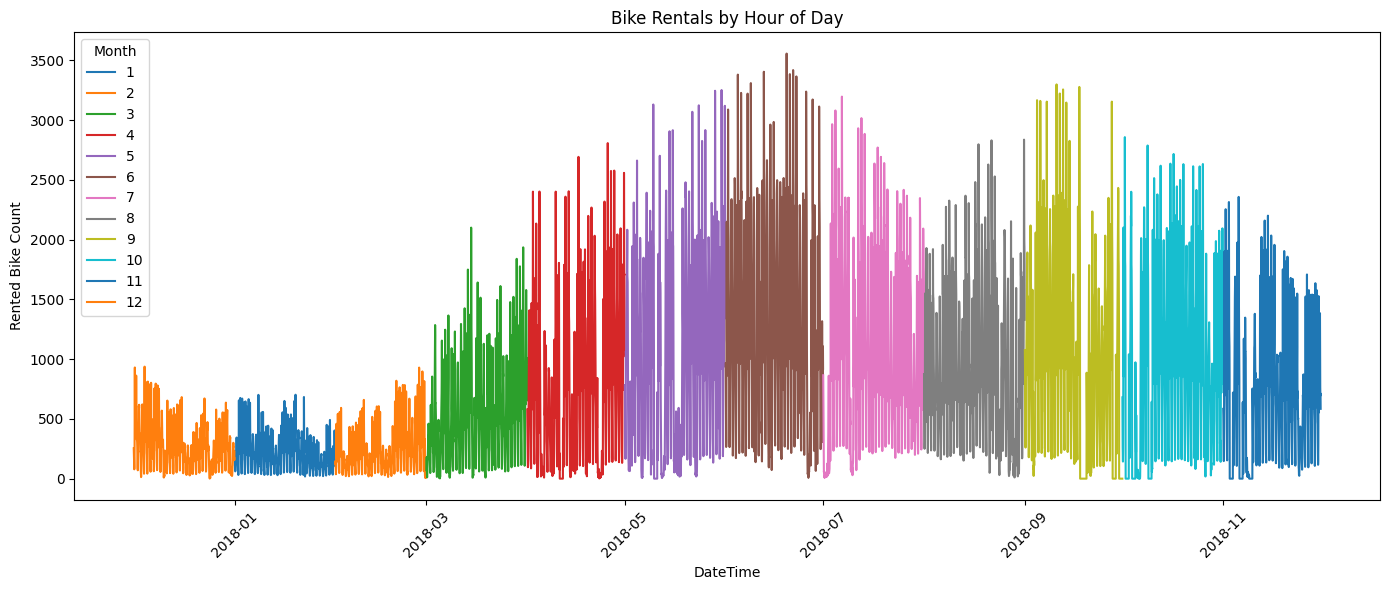

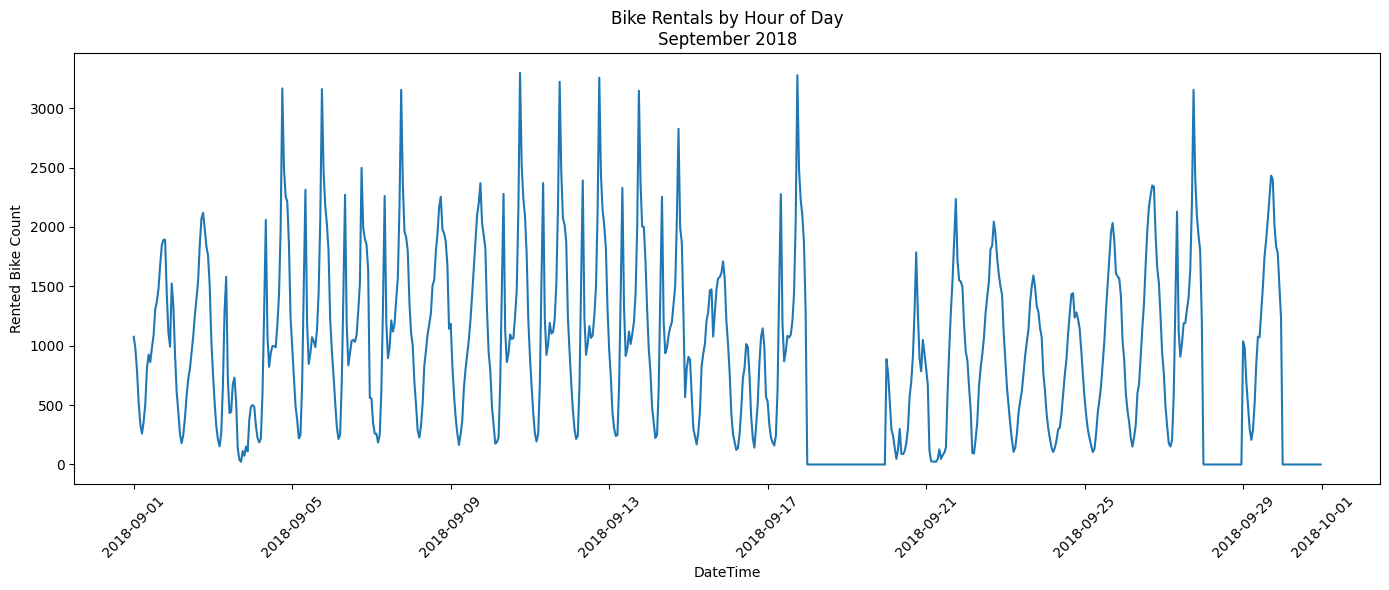

In [55]:
#=================================================================
# Step 3: Response Variable
plt.figure(figsize=(14, 6)) 
sns.lineplot(
    data=df2,
    x='DateTime',
    y='Rented Bike Count',
    hue='Month',
    palette='tab10',
    legend='full',
)
plt.xticks(rotation=45)
plt.title('Bike Rentals by Hour of Day')
plt.xlabel('DateTime')
plt.ylabel('Rented Bike Count')
plt.tight_layout()  
plt.show()


plt.figure(figsize=(14, 6)) 
sns.lineplot(
    data=df2[df2['Month']==9],
    x='DateTime',
    y='Rented Bike Count',
    legend='full',
)
plt.xticks(rotation=45)
plt.title('Bike Rentals by Hour of Day\nSeptember 2018')
plt.xlabel('DateTime')
plt.ylabel('Rented Bike Count')
plt.tight_layout()  
plt.show()
#=================================================================

In [ ]:
#=================================================================
# Step 4: Remove Hours Not Functioning
df3 = copy.deepcopy(df2[df2['Functioning Day']=='Yes'])

# Columns to keep
cols=['Rented Bike Count', 'Seasons', 'Holiday', 'Month', 'DayOfWeek','Hour', 
'Temperature','Humidity','Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall']
df3 = df3[cols]
#=================================================================

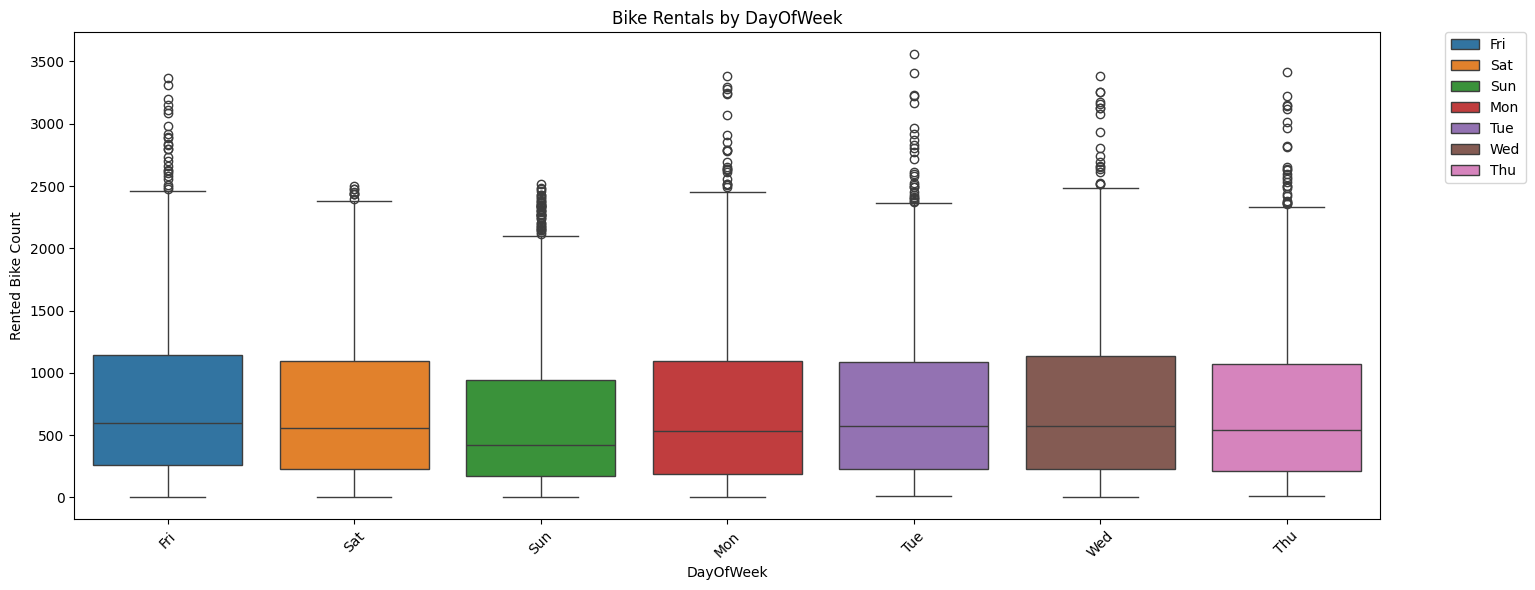

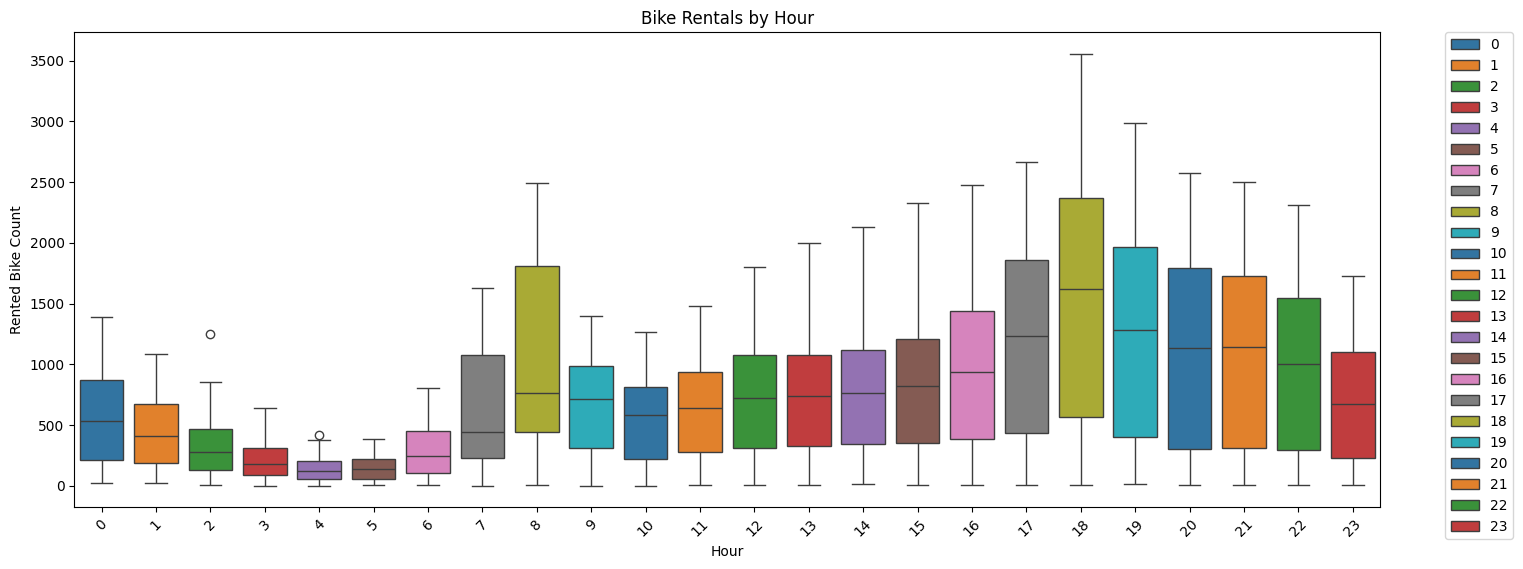

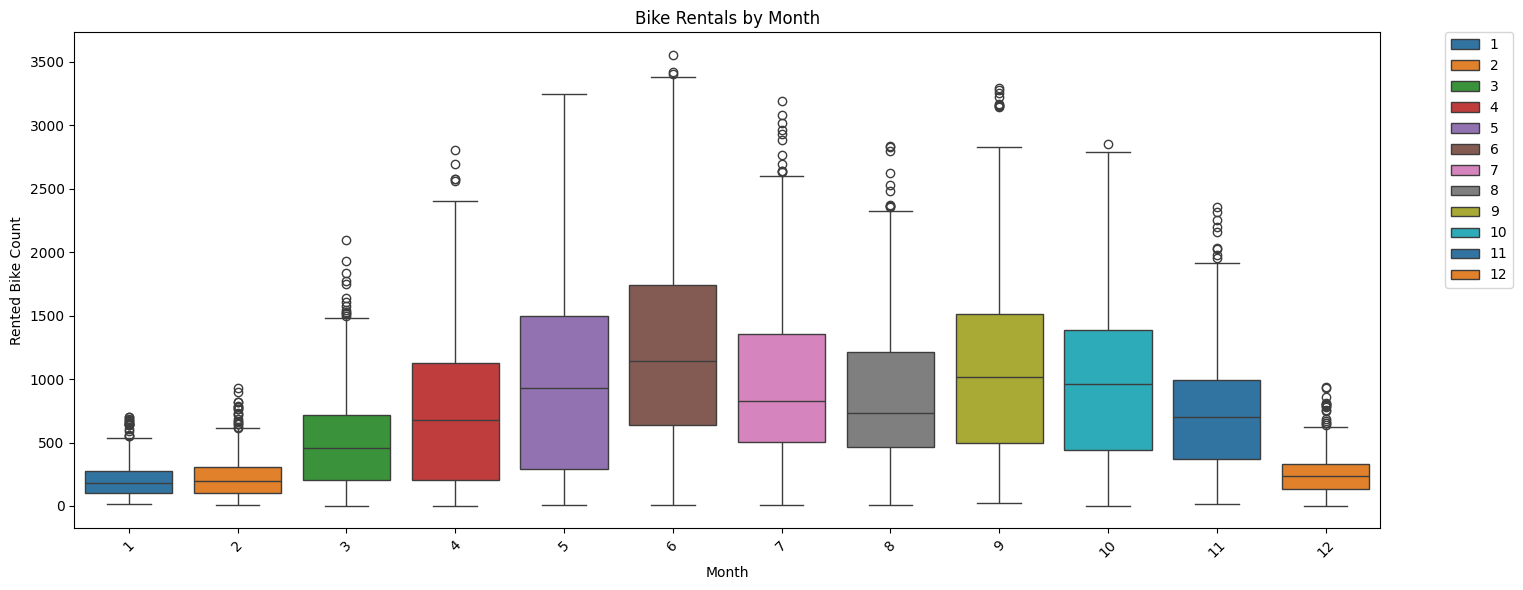

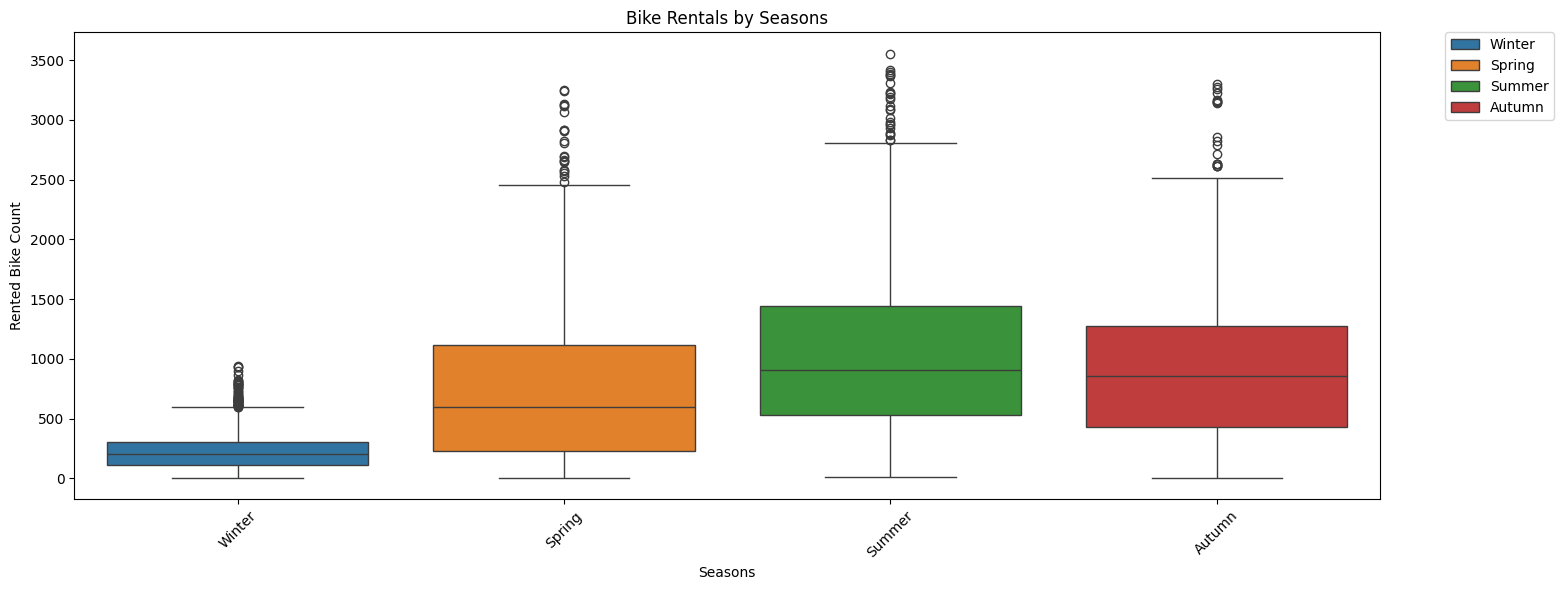

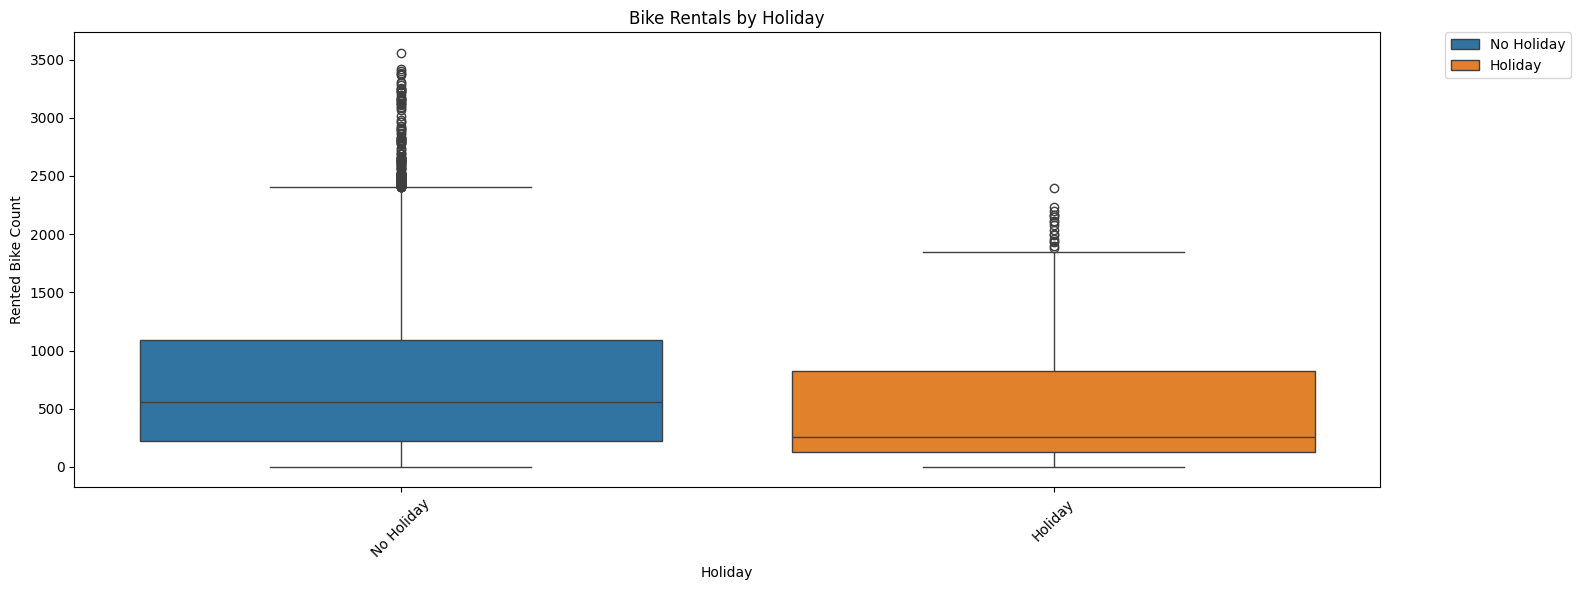

In [76]:
for thisVar in ['DayOfWeek', 'Hour', 'Month', 'Seasons', 'Holiday']:
    # Create boxplot for each variable

    plt.figure(figsize=(14, 6)) 
    sns.boxplot(
        data=df3,
        x=thisVar,
        y='Rented Bike Count',
        hue=thisVar,
        palette='tab10',
        legend='full',
    )
    plt.xticks(rotation=45)
    plt.title(f'Bike Rentals by {thisVar}')
    plt.xlabel(thisVar)
    plt.ylabel('Rented Bike Count')
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


In [ ]:
'Temperature','Humidity','Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall']
